In [1]:
import os
import cv2
import tensorflow as tf
from tensorflow import keras 


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
import numpy as np
from matplotlib import pyplot as plt

%env SM_FRAMEWORK=tf.keras
%pip install segmentation_models
import segmentation_models as sm

from tensorflow.python.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

import random

env: SM_FRAMEWORK=tf.keras
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Segmentation Models: using `tf.keras` framework.


In [3]:
root_directory = '/kaggle/input/testing/'


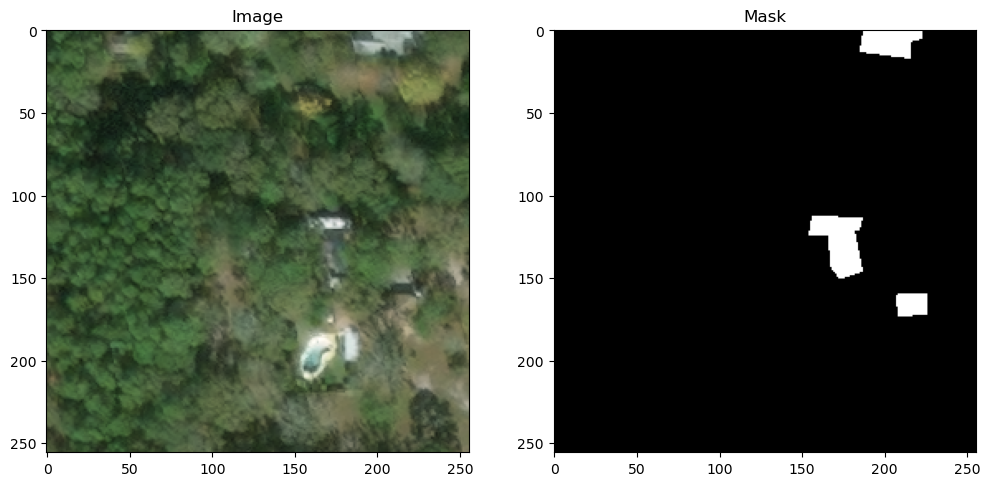

In [4]:
#Get an understanding by looking at a few random images and masks 

train_img_dir = root_directory+"test_images/images/"
train_mask_dir = root_directory+"test_masks/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 1)
mask_for_plot = cv2.cvtColor(mask_for_plot, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot)
plt.title('Mask')
plt.show()

In [5]:
seed=24
np.random.seed(seed)
tf.random.set_seed(seed)
batch_size= 16
n_classes=5

In [6]:
nodamage=np.array([255,255,255]) #White
minordamage=np.array([0,255,0]) #Green
majordamage=np.array([0,0,255]) #Blue
destroyed=np.array([255,0,0]) #Red
unclassified=np.array([0,0,0]) #Black

In [7]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == nodamage,axis=-1)] = 0
    label_seg [np.all(label==minordamage,axis=-1)] = 1
    label_seg [np.all(label==majordamage,axis=-1)] = 2
    label_seg [np.all(label==destroyed,axis=-1)] = 3
    label_seg [np.all(label==unclassified,axis=-1)] = 4
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [8]:
def preprocess_data(img, mask, n_classes):
    labels = []
    for i in range(mask.shape[0]):
        label = rgb_to_2D_label(mask[i])
        labels.append(label)    

    labels = np.array(labels)   
    labels = np.expand_dims(labels, axis=3)

    labels_cat = to_categorical(labels, num_classes=n_classes)
    img_prepr = preprocess_input(img)
    return (img_prepr, labels_cat)

In [9]:
def trainGenerator(train_img_path, train_mask_path, num_class):
    img_data_gen_args = dict(
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
    )

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode=None,  # Set class_mode to None
        batch_size=batch_size,
        seed=seed
    )
   
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode=None,  # Set class_mode to None
        batch_size=batch_size,
        seed=seed,
        color_mode='rgb'  # Set color_mode to 'rgb'
    )

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)


In [10]:
BACKBONE = 'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [11]:
test_img_path = root_directory+"test_images/"
test_mask_path = root_directory+"test_masks/"
test_img_gen = trainGenerator(test_img_path, test_mask_path, num_class=5)

In [12]:
x,y= test_img_gen.__next__()

Found 2462 images belonging to 1 classes.
Found 2462 images belonging to 1 classes.


In [13]:
print(x.shape)
print(y.shape)
print("Unique labels in label dataset are: ", np.unique(y))
print(type(x))
print(y.shape)

(16, 256, 256, 3)
(16, 256, 256, 5)
Unique labels in label dataset are:  [0. 1.]
<class 'numpy.ndarray'>
(16, 256, 256, 5)


In [14]:
model = load_model("/kaggle/input/samplemodel/seed24.hdf5", compile=False)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
#Test generator using validation data.

test_image_batch, test_mask_batch = test_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 8s 8s/step
Mean IoU = 0.54243886


In [16]:
iou_per_class = []

for class_id in range(n_classes):
    mask_class = test_mask_batch_argmax == class_id
    pred_class = test_pred_batch_argmax == class_id
    
    intersection = np.logical_and(mask_class, pred_class)
    union = np.logical_or(mask_class, pred_class)
    
    iou = np.sum(intersection) / np.sum(union)
    iou_per_class.append(iou)

print("IoU per class:", iou_per_class)

IoU per class: [0.6765953123245331, 0.3228112774854984, nan, 0.24180327868852458, 0.9285455928078215]


/tmp/ipykernel_28/1388848243.py:10: RuntimeWarning: invalid value encountered in long_scalars
  iou = np.sum(intersection) / np.sum(union)


In [17]:
f1_per_class = []

for class_id in range(n_classes):
    mask_class = test_mask_batch_argmax == class_id
    pred_class = test_pred_batch_argmax == class_id
    
    f1 = f1_score(mask_class.flatten(), pred_class.flatten())
    f1_per_class.append(f1)

mean_f1 = np.mean(f1_per_class)

print("F1 score per class:", f1_per_class)
print("Mean F1 score:", mean_f1)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


F1 score per class: [0.807106291364325, 0.48806852947175194, 0.0, 0.3894389438943894, 0.9629490702949127]
Mean F1 score: 0.5295125670050758


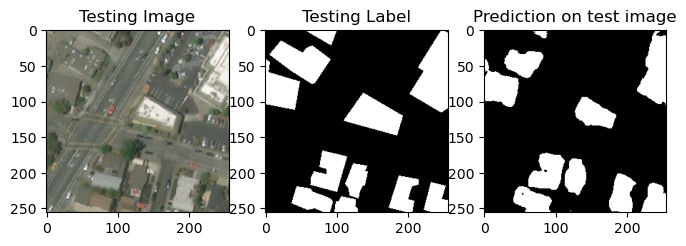

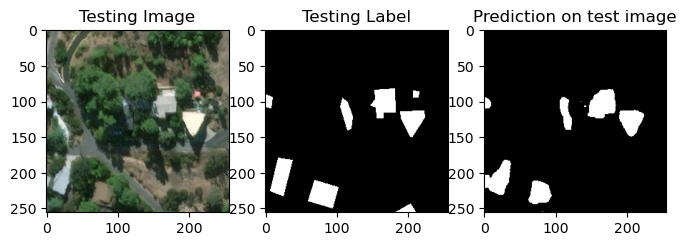

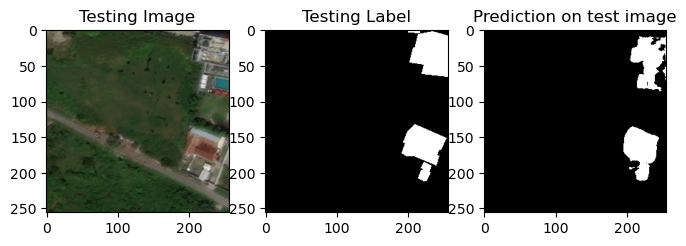

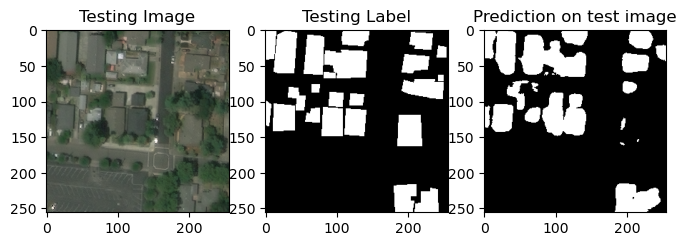

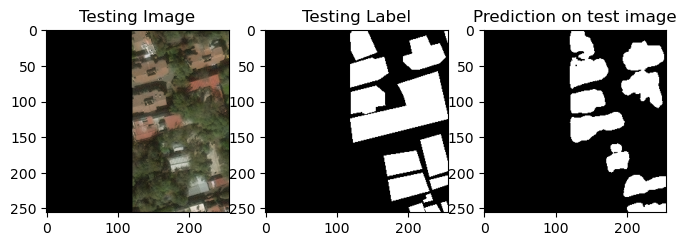

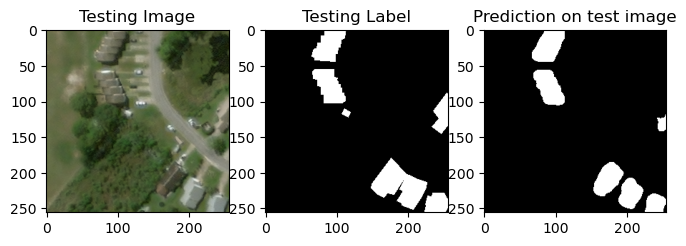

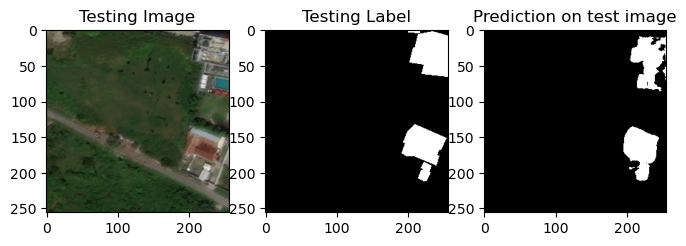

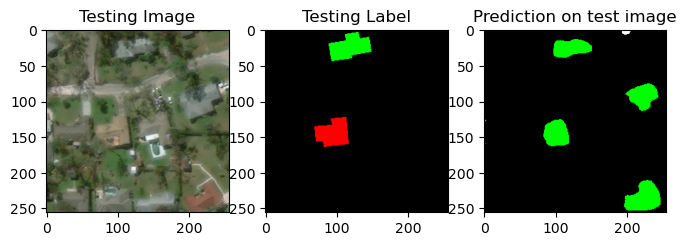

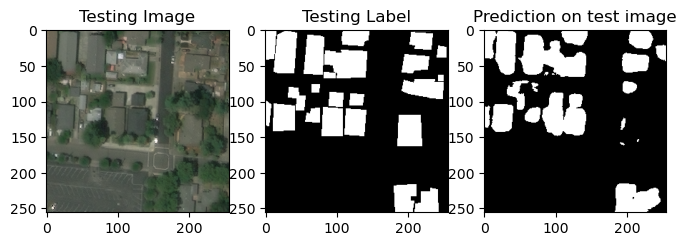

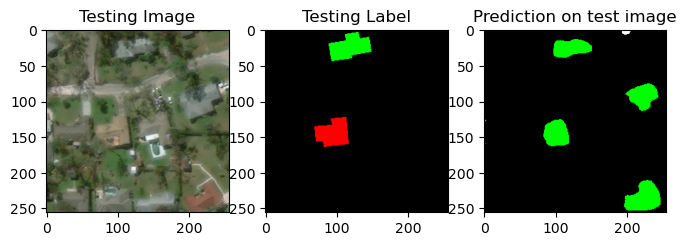

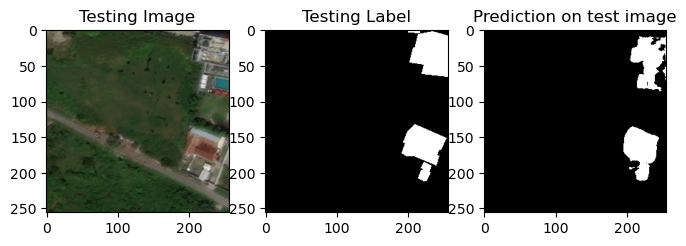

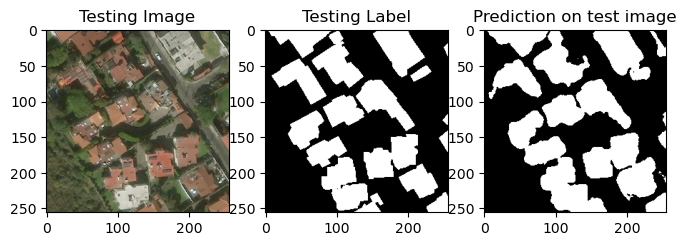

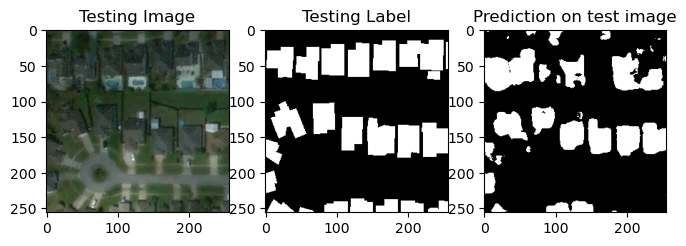

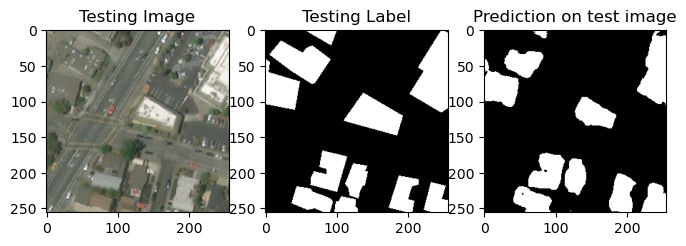

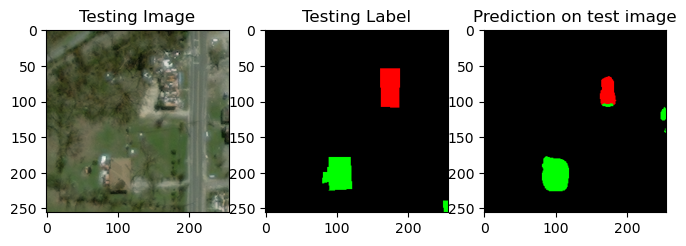

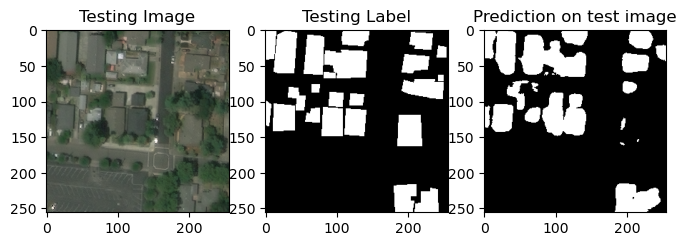

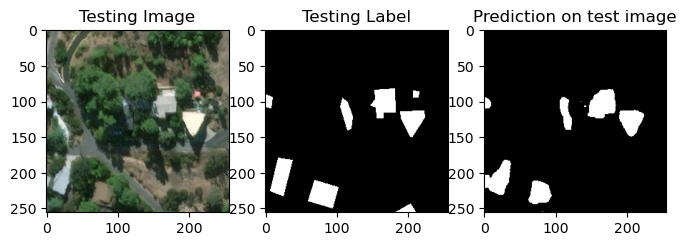

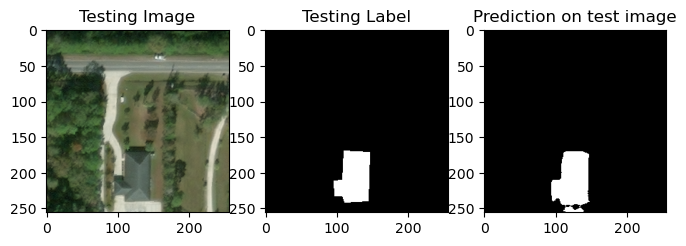

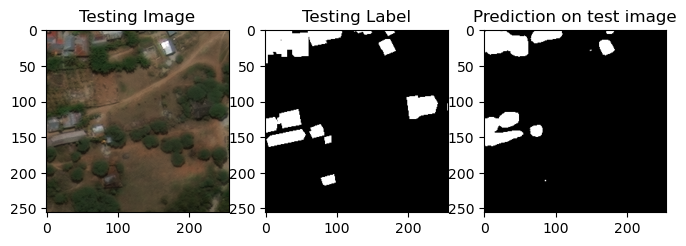

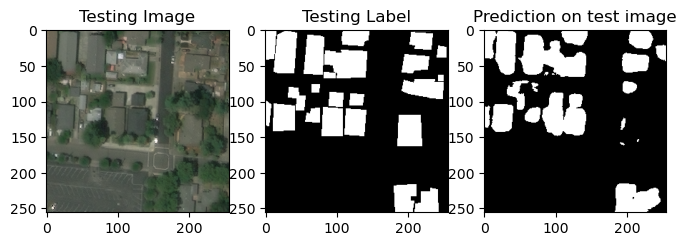

In [18]:
# Define the RGB values for each class
class_colors = {
    0: [255, 255, 255],  # nodamage (White)
    1: [0, 255, 0],      # minordamage (Green)
    2: [0, 0, 255],      # majordamage (Blue)
    3: [255, 0, 0],      # destroyed (Red)
    4: [0, 0, 0]         # unclassified (Black)
}

# Convert class labels to RGB images
def labels_to_rgb(labels):
    h, w = labels.shape[:2]
    rgb_labels = np.zeros((h, w, 3), dtype=np.uint8)
    
    for class_id, color in class_colors.items():
        rgb_labels[np.where(labels == class_id)] = color
    
    return rgb_labels

# Plot the random predictions
num_results = 20  # Number of random results to view

for _ in range(num_results):
    img_num = random.randint(0, test_image_batch.shape[0] - 1)
    
    image=test_image_batch[img_num]
    min_val = np.min(image)
    max_val = np.max(image)

    # Shift and scale the array
    shifted_img = image - min_val
    scaled_img = shifted_img / (max_val - min_val)
    scaled_img = scaled_img * 2 - 1
    rescaled_image = (scaled_img + 1) / 2 * 255
    rescaled_image = np.round(rescaled_image).astype(int)
    
    plt.figure(figsize=(8, 6))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(rescaled_image)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(labels_to_rgb(test_mask_batch_argmax[img_num]))
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(labels_to_rgb(test_pred_batch_argmax[img_num]))
    plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


IndexError: index 4 is out of bounds for axis 1 with size 4

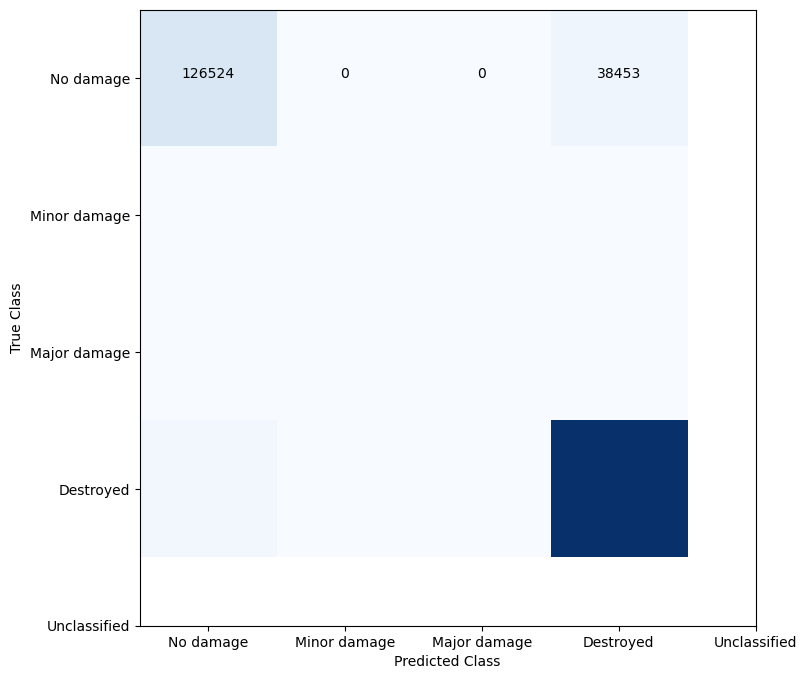

In [19]:
true_labels = test_mask_batch_argmax.flatten()
predicted_labels = test_pred_batch_argmax.flatten()
num_classes = n_classes

# Define the class labels
class_labels = ['No damage', 'Minor damage', 'Major damage', 'Destroyed', 'Unclassified']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Compute precision and recall for each class
precision_per_class = []
recall_per_class = []
for class_id in range(num_classes):
    precision = precision_score(true_labels, predicted_labels, labels=[class_id], average='micro')
    recall = recall_score(true_labels, predicted_labels, labels=[class_id], average='micro')
    precision_per_class.append(precision)
    recall_per_class.append(recall)

# Compute overall accuracy
accuracy = np.trace(cm) / np.sum(cm)

# Increase cell width
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Add number of instances as text in each cell
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

# Add precision values in the additional column
for i in range(num_classes):
    plt.text(num_classes, i, f'{precision_per_class[i]:.5f}',
             horizontalalignment="center", verticalalignment='center')

# Add recall values in the additional row
for j in range(num_classes):
    plt.text(j, num_classes, f'{recall_per_class[j]:.5f}',
             horizontalalignment="center", verticalalignment='center')

# Print overall accuracy at the intersection of precision and recall rows and columns
plt.text(num_classes, num_classes, f'Accuracy: {accuracy:.5f}',
         horizontalalignment="center", verticalalignment='center')

# Add labels "Recall" and "Precision" to the respective row and column
plt.text(num_classes, -0.5, "Precision",
         horizontalalignment="center", verticalalignment='center')
plt.text(-0.5, num_classes, "Recall",
         horizontalalignment="center", verticalalignment='center')

# Move x axis ticks and label to the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_coords(0.5, 1.08)
plt.xlabel('Predicted Class')

plt.tight_layout()  # Adjust spacing between subplots

plt.show()
